In [1]:
# pip install selenium==3.141.0
# pip install community_louvain


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import time
import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from matplotlib import pyplot as plt
import os
import re

In [2]:
import spacy
NER = spacy.load("en_core_web_sm")

In [3]:
import networkx as nx
from pyvis.network import Network
import community as community_louvain

Define driver object

In [5]:
driver = webdriver.Chrome(ChromeDriverManager().install())

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 103.0.5060
[WDM] - Get LATEST chromedriver version for 103.0.5060 google-chrome
[WDM] - Driver [C:\Users\ammad\.wdm\drivers\chromedriver\win32\103.0.5060.134\chromedriver.exe] found in cache


Push page url to get list of charachters for the witcher book using witcher fanpage "https://witcher.fandom.com/wiki/Category:Characters_in_the_stories"

In [6]:
page_url = "https://witcher.fandom.com/wiki/Category:Characters_in_the_stories"
driver.get(page_url)

In [7]:
book_cat = driver.find_elements_by_class_name('category-page__member-link')
# for item in book_cat:
#     print(item.text)

# make a list "books" that has book name and its link
books = []
for item in book_cat:
    book_name=item.text
    link=item.get_attribute('href')
    books.append({'Name':book_name, 'Link':link})

# direct driver to book link and append the name of characheter to list "chars"
# use time.sleep to allow for the page to load
chars=[]
for book in books:
    driver.get(book['Link'])
    time.sleep(2)
    char_names= driver.find_elements_by_class_name('category-page__member-link')
    for item in char_names:
        chars.append({'Book':book['Name'], 'Character':item.text})


In [9]:
# create a dataframe and pass the list "chars" to it
chardf=pd.DataFrame(chars)
chardf

,Book,Character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
...,...,...
1270,Category:Time of Contempt characters,Yanna of Murivel
1271,Category:Time of Contempt characters,Yarpen Zigrin
1272,Category:Time of Contempt characters,Yennefer of Vengerberg
1273,Category:Time of Contempt characters,Yiolenta Suarez


<function matplotlib.pyplot.show(close=None, block=None)>

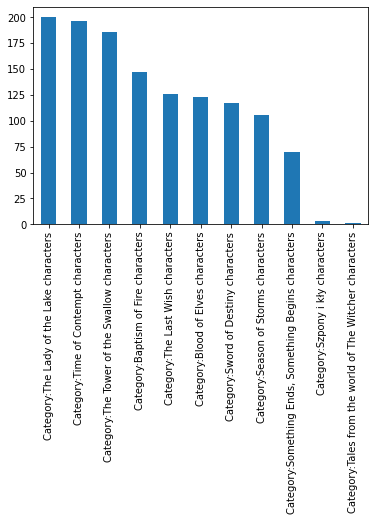

In [10]:
# graph number of charachters in books
chardf['Book'].value_counts().plot(kind='bar')
plt.show

Get names of book text  

In [11]:
all_books = [b for b in os.scandir('..\..\data') if '.txt' in b.name]
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>]

Read Books & pass to spacy's NER 

In [12]:
book = all_books[0]
book_text = open(book).read()
book_doc = NER(book_text)

In [13]:
# Replace all separators by " "
chardf['Character'] = chardf['Character'].apply(lambda x: re.sub("[[\(.*?\)]]", "", x))
# Get First names only
chardf['character_firstname'] = chardf['Character'].apply(lambda x: x.split(" ",1)[0] )
# chardf.head(9)

C:\Users\ammad\AppData\Local\Temp\ipykernel_7220\2368929191.py:2: FutureWarning: Possible nested set at position 1
  chardf['Character'] = chardf['Character'].apply(lambda x: re.sub("[[\(.*?\)]]", "", x))


In [14]:
# chardf.to_csv("chardf_fnames.csv")

Iterate through sentences and create DataFrame of entities 

In [15]:
sent_entity=[]
# doc.sents Iterate over the sentences in the document
# sent.ents grabs all entities in the sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity.append({"sentence":sent, "entities":entity_list})
sent_entity_df = pd.DataFrame(sent_entity)
# sent_entity_df

In [16]:
sent_entity_df.head(15)

,sentence,entities
0,"(ï»¿'Does, she, always, devour, her, victims, ...",[]
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad]
2,"(\n\n, ', Come, on, ,, Geralt, ,, it, 'll, be,...",[]
3,"(Pish, !)",[]
4,"(Devours, ,, takes, a, bite, ,, leaves, aside,...",[]
5,"(She, only, bit, the, head, from, one, ,, gutt...",[]
6,"(Damned, mother's-, !, ')",[]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]"
8,"(Say, what, you, want, about, the, striga, but...",[]
9,"(\n\n, ', Has, anyone, she, 's, attacked, surv...",[]


Function filter_entity filters entities passed from chardf_fnames to match names

In [17]:
def filter_entity(ent_list, chardf):
    return[ent for ent in ent_list
          if ent in list(chardf.Character)
          or ent in list(chardf.character_firstname)]

In [18]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x:filter_entity(x, chardf))

sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len)>0]
sent_entity_df_filtered.head(15)

,sentence,entities,character_entities
1,"(\n\n, Velerad, spat, vehemently, on, the, str...",[Velerad],[Velerad]
7,"(\n\n, ', Careful, ,, Velerad, ,, ', snarled, ...","[Velerad, Ostrit]","[Velerad, Ostrit]"
11,"(\n\n, Segelin, and, Ostrit, looked, at, each,...","[Segelin, Ostrit]","[Segelin, Ostrit]"
16,"(And, then, ,, ', interrupted, Velerad, ,, ', ...",[Velerad],[Velerad]
27,"(\n\n, Having, finished, his, examination, Ger...",[Geralt],[Geralt]
30,"(It, was, Foltest, himself, .)",[Foltest],[Foltest]
62,"(\n\n, Yes, ,, ', Foltest, bristled, ., ')",[Foltest],[Foltest]
74,"(\n\n, Foltest, looked, the, Rivian, in, the, ...","[Foltest, Rivian]",[Foltest]
83,"(\n\n, Foltest, got, up, ., ')",[Foltest],[Foltest]
123,"(\n\n, Foltest, grew, gloomy, .)",[Foltest],[Foltest]


Look for Relationships over a window of 5 sentences

In [22]:
window_size = 5
relationships = []
for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum( (sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    char_unique = [char_list[i] for i in range (len(char_list))
                  if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique)>1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx +1]
            relationships.append({'source':a, 'target':b})
relationship_df=pd.DataFrame(relationships)

In [23]:
relationship_df

,source,target
0,Velerad,Ostrit
1,Velerad,Ostrit
2,Velerad,Ostrit
3,Velerad,Ostrit
4,Velerad,Ostrit
...,...,...
1126,Iola,Nenneke
1127,Iola,Nenneke
1128,Geralt,Nenneke
1129,Geralt,Nenneke


In [24]:
# Sort values
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis=1), columns=relationship_df.columns)
# create value colum with defualt value of 1
# group - then sum
relationship_df['value']=1
relationship_df = relationship_df.groupby(['source', 'target'], sort=False, as_index=False).sum()

Graph Analysis and visualisation

- Network diagrams (also called Graphs) show interconnections between a set of entities. Each entity is represented by a Node (or vertice). Connections between nodes are represented through links (or edges).

In [25]:
G= nx.from_pandas_edgelist(relationship_df,
                         source = 'source',
                         target = 'target',
                         edge_attr = 'value',
                         create_using = nx.Graph())

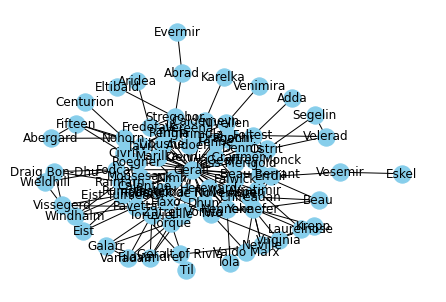

In [26]:
# graph visualisation using kamada_kawai_layout

pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [27]:
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

# A DegreeView for the Graph as G.degree or G.degree().
# The node degree is the number of edges adjacent to the node. 

node_degree= dict(G.degree)
# set_node_attributes(G, values, name=None)
nx.set_node_attributes(G, node_degree, "size")

net.from_nx(G)
net.show('witcher.html')

Find the best partition of a graph using the Louvain Community Detection Algorithm

In [28]:
communities = community_louvain.best_partition(G)

In [30]:
nx.set_node_attributes(G, communities, 'group')
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

net.from_nx(G)
net.show('witcher.html')